In [2]:
import hdf5storage
from helpers import *
from get_data import *
from synchrony import *
import numpy as np


%load_ext autoreload
%autoreload 2


### Loading in the bat data (LFP and positional data)
#### We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a matlab file (not accessible for public use), but luckily the accessors for this data can be found in ```dataset.py``` thanks to the Yartsev Lab.

In [ ]:
data_path = './data'
bat_id = '32622'
date = '231007'
lfp_file_path = './data/ephys/32622_231007_lfp.mat'


#Clean up position data (remove NaNs, etc.) and load in LFP from given file path
lfp_mat, cleaned_pos, session = load_and_clean_bat_data(data_path, bat_id, date, lfp_file_path,use_cache=True)

### Time synchronization
#### Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [4]:
dsr = 100 #desired sampling rate

In [53]:
lfp_timestamps_edges, binned_pos, pos_timestamps, lfp_indices, pos_mask = sync_and_bin_data(lfp_mat, session,cleaned_pos,fs=dsr)

#lfp_timestamp_edges stores edges between timebins. this will be useful for aligning the LFP data with the position data
#binned_pos is the cleaned position averaged over the timebins
#pos_mask is a boolean array that marks the non-negative position timestamps
#pos_timestamps is the cleaned and filtered timestamps of the position data
#lfp_indices is a boolean array that marks the non-negative, decimated LFP timestamps


LFP timestamps structure: (17222917, 1)
Decimation factor: 25
Decimated LFP timestamps shape: (688917,)
LFP timestamp edges shape: (682758,)
Positional timestamp diff (microseconds): [8333.33333331 8333.33333334 8333.33333334 ... 8333.33772278 8333.33771515
 8333.33771515]
Cleaned positional data shape: (824435, 3)
Binned positional data shape: (682757, 3)


In [ ]:
print("Number of NaN values in binned_pos:", np.isnan(binned_pos).sum())


#### Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average across bins (between two edges) of the LFP timebins to get synchronized data streams.

In [44]:
print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

First few elements of binned_pos:
 [[        nan         nan         nan]
 [-1.35498553 -1.70192744  0.01014751]
 [-1.35498155 -1.70192304  0.01015784]
 ...
 [-1.24499005 -1.62757397  0.04333328]
 [-1.24497874 -1.62756816  0.04337698]
 [        nan         nan         nan]]
First few LFP bins: [    0.          4514.44262607 14400.08341309 24285.72420011
 34171.36498713]


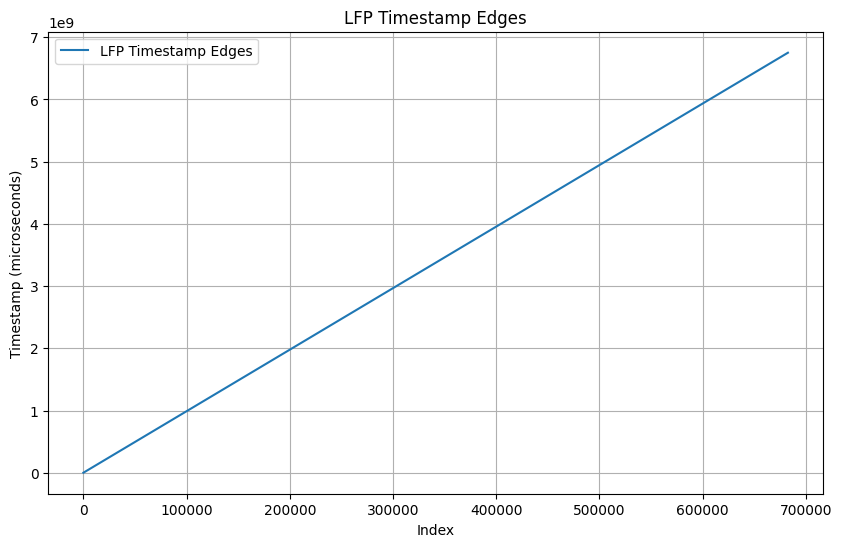

In [45]:
import matplotlib.pyplot as plt

# Plotting lfp_timestamps_edges
plt.figure(figsize=(10, 6))
plt.plot(lfp_timestamps_edges, label='LFP Timestamp Edges')
plt.xlabel('Index')
plt.ylabel('Timestamp (microseconds)')
plt.title('LFP Timestamp Edges')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
print("Shape of lfp_timestamps_edges:", lfp_timestamps_edges.shape)
print("Shape of LFPs:", LFPs.shape)

Shape of lfp_timestamps_edges: (682758,)
Shape of LFPs: (682757, 384)


In [57]:
lfp_timestamps_edges_trim = lfp_timestamps_edges[:-1]
print(lfp_timestamps_edges_trim.shape)

(682757,)


##### Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

# Ben splits cluster 3

In [ ]:
lfp_bat_combined = extract_and_downsample_lfp_data(lfp_mat,2500,dsr,use_cache=False) #uses scipy decimate to downsample LFP
#LFPs = filter_data(lfp_bat_combined, 1, fs=25, filt_type='high', use_hilbert=True) 
LFPs = lfp_bat_combined[lfp_indices] # mask for non-negativity 

In [59]:
lfp_time_diffs = np.diff(lfp_timestamps_edges)

# Convert the time differences to seconds
lfp_time_diffs_seconds = lfp_time_diffs / 1e6

# Calculate the mean of the time differences in seconds
mean_lfp_time_diff_seconds = np.mean(lfp_time_diffs_seconds)

# Calculate the sampling rate
lfp_sampling_rate = 1 / mean_lfp_time_diff_seconds

print(f"Estimated sampling rate of LFP timestamp edges: {lfp_sampling_rate} Hz")

Estimated sampling rate of LFP timestamp edges: 101.12510604668914 Hz


In [ ]:
# Extract all flights in the third cluster
flights_cluster = session.get_flights_by_cluster((2,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the minimum and maximum x-values
min_x_value = np.min(x_values)
max_x_value = np.max(x_values)

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the 3% buffer based on the range of x-values
x_range = max_x_value - min_x_value
buffer = 0.03 * x_range

# Define the range with the buffer around the median
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

print(f"Median x-value position: {median_x_value}")
print(f"Buffer range: ({lower_bound}, {upper_bound})")
# Extract all y-values from the flights
y_values = np.concatenate([flight.filtered_position[:, 1] for flight in flights_cluster])
y_values = y_values[~np.isnan(y_values)]

# Calculate the minimum and maximum y-values
min_y_value = np.min(y_values)
max_y_value = np.max(y_values)

# Calculate the median of the y-values
median_y_value = np.median(y_values)

# Calculate the 3% buffer based on the range of y-values
y_range = max_y_value - min_y_value
buffer_y = 0.03 * y_range

# Define the range with the buffer around the median
lower_bound_y = median_y_value - buffer_y
upper_bound_y = median_y_value + buffer_y

print(f"Median y-value position: {median_y_value}")
print(f"Buffer range: ({lower_bound_y}, {upper_bound_y})")

# color plots of median

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Extract all flights in the second cluster
flights_cluster = session.get_flights_by_cluster((2,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the buffer range
x_range = np.max(x_values) - np.min(x_values)
buffer = 0.03 * x_range
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

# Plot 3D flight paths, coloring based on the x-position relative to the median and buffer
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors for the regions
left_color = 'blue'
right_color = 'red'
buffer_color = 'black'

for flight in flights_cluster:
    # Extract the position data
    pos = flight.filtered_position
    x_coords, y_coords, z_coords = pos[:, 0], pos[:, 1], pos[:, 2]
    
    # Clean NaN values
    valid_mask = ~np.isnan(x_coords) & ~np.isnan(y_coords) & ~np.isnan(z_coords)
    x_coords, y_coords, z_coords = x_coords[valid_mask], y_coords[valid_mask], z_coords[valid_mask]
    
    # Determine colors for each segment based on x-coordinates
    for i in range(len(x_coords) - 1):
        # Assign color based on the position relative to the buffer
        if lower_bound <= x_coords[i] <= upper_bound:
            segment_color = buffer_color
        elif x_coords[i] < lower_bound:
            segment_color = left_color
        else:
            segment_color = right_color
        
        # Plot the line segment with the determined color
        ax.plot(x_coords[i:i+2], y_coords[i:i+2], z_coords[i:i+2], color=segment_color)

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('Flight Paths Colored by Position Relative to Median X and Buffer')

# Add a legend
legend_handles = [
    Line2D([0], [0], color=left_color, lw=4, label='Left of Buffer'),
    Line2D([0], [0], color=right_color, lw=4, label='Right of Buffer'),
    Line2D([0], [0], color=buffer_color, lw=4, label='Within Buffer'),
    Line2D([0], [0], color='black', lw=0, marker='', markersize=0, label=f'Median X: {median_x_value:.2f}'),
    Line2D([0], [0], color='black', lw=0, marker='', markersize=0, label=f'Buffer: ±{buffer:.2f}')
]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the view
ax.view_init(elev=50, azim=-120)

# Show the plot
plt.show()


In [12]:
def left_or_right(x, lower,upper):
    # Classify the input x values
    return np.where(
        x < lower, "left",  # Values less than the lower buffer are "left"
        np.where(x > upper, "right", "within buffer")  # Values greater than the upper buffer are "right"
    )

##### getting the binned position to match corresponding flights:
flight_count =0
flight_data = []

for flight in session.get_flights_by_cluster([2]): #marking cluster 3 flights
    flight_count +=1
    flight_bool, _, _ = get_flight_boolean_array(session,flight_count)

    # Apply pos_mask (formerly valid_indices) to the flight boolean array and phase labels
    labels = flight_bool[pos_mask]
     # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
    
    flight_lfp = LFPs[timebin_labels > 0] # mark LFP points which mask to specific flight in cluste

     # Get binned position data for this flight
    flight_pos = binned_pos[timebin_labels > 0]
    
####### Current analysis task: marking whether current x is less than or greater than x=0
    flight_data.append(np.column_stack((
        np.full(len(flight_pos), flight_count),
        left_or_right(flight_pos[:,1], lower_bound_y, upper_bound_y),
        flight_lfp
    )))
    


In [13]:
flight_data = np.vstack(flight_data)

In [ ]:
flight_data

# Spectrogram of each flight w/in cluster 2

In [60]:
lfp_timestamps_sec = lfp_timestamps_edges_trim / 1e6

Flight 1: Flight LFP shape: (1254, 384)


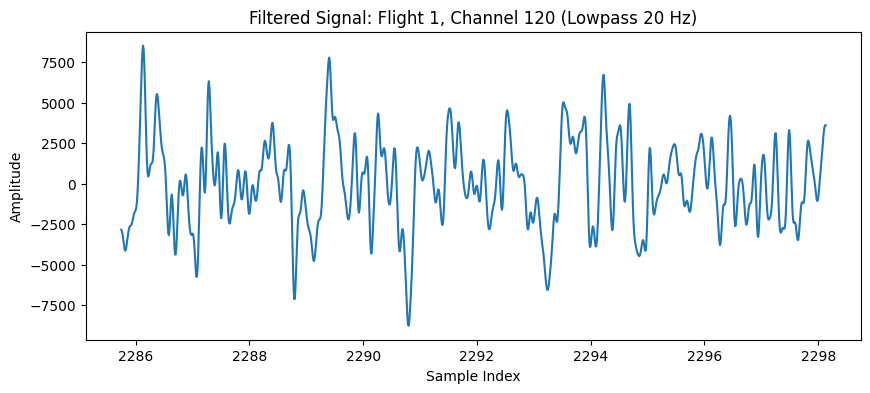

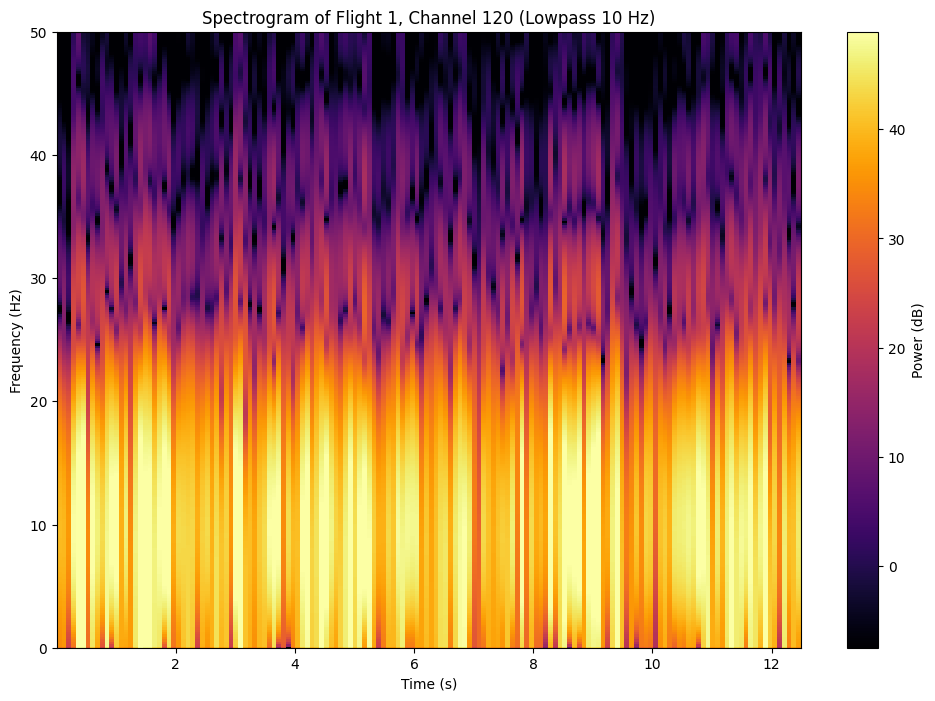

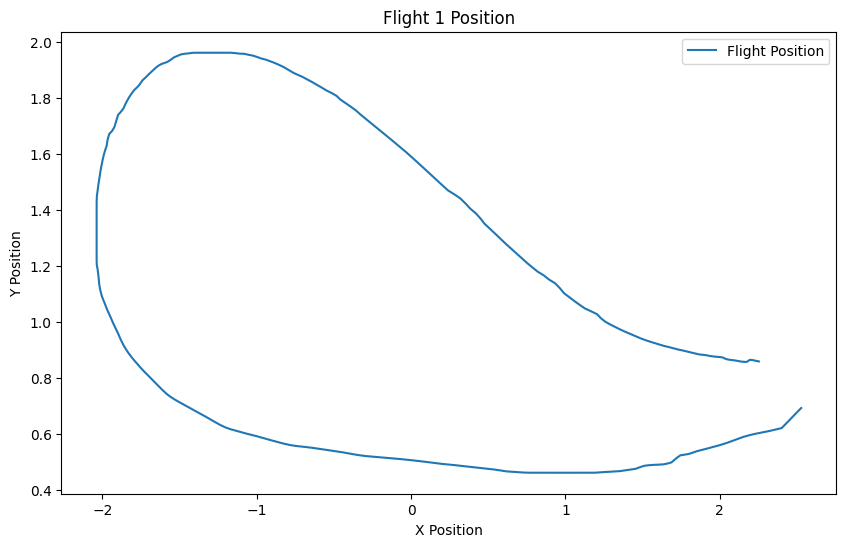

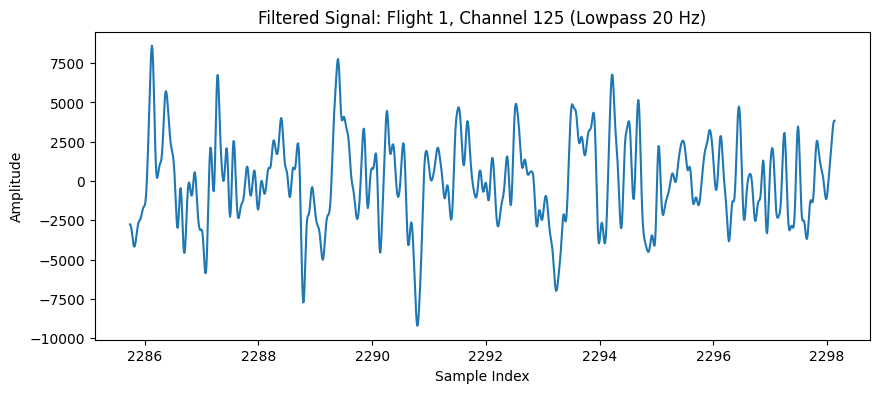

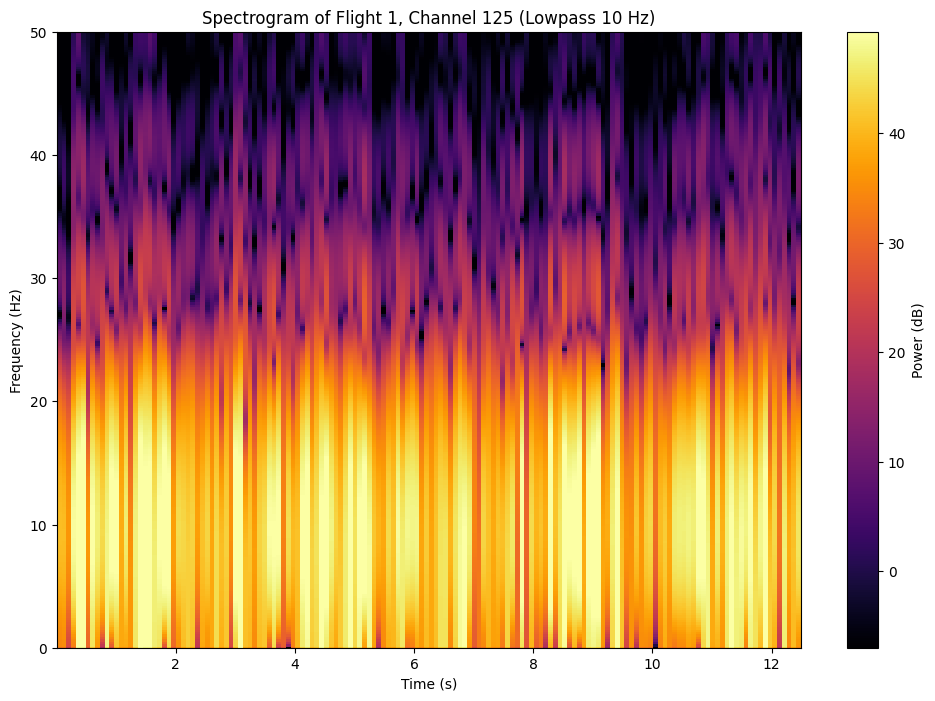

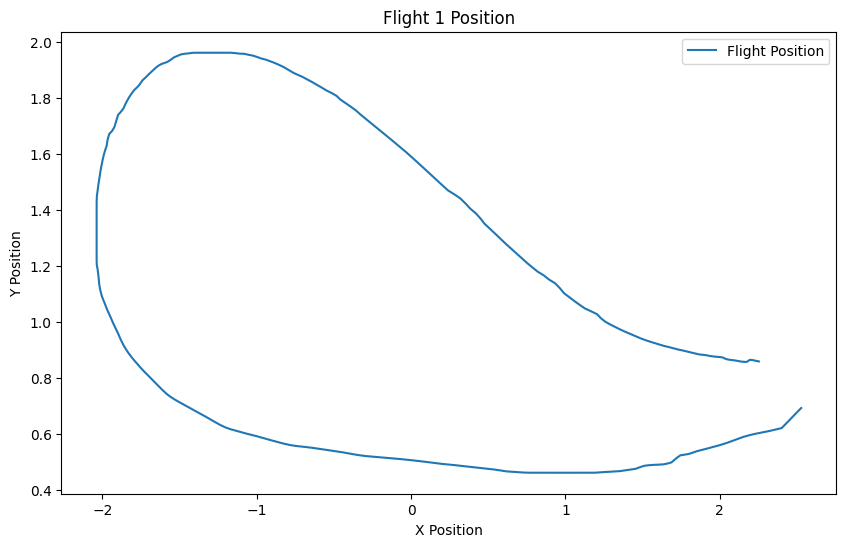

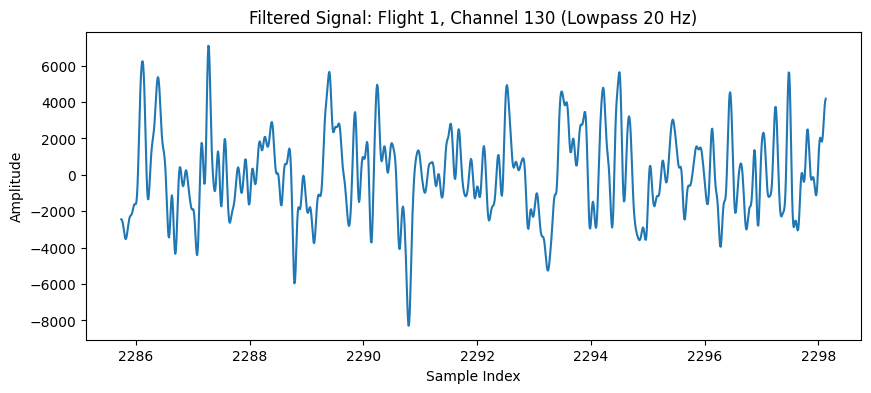

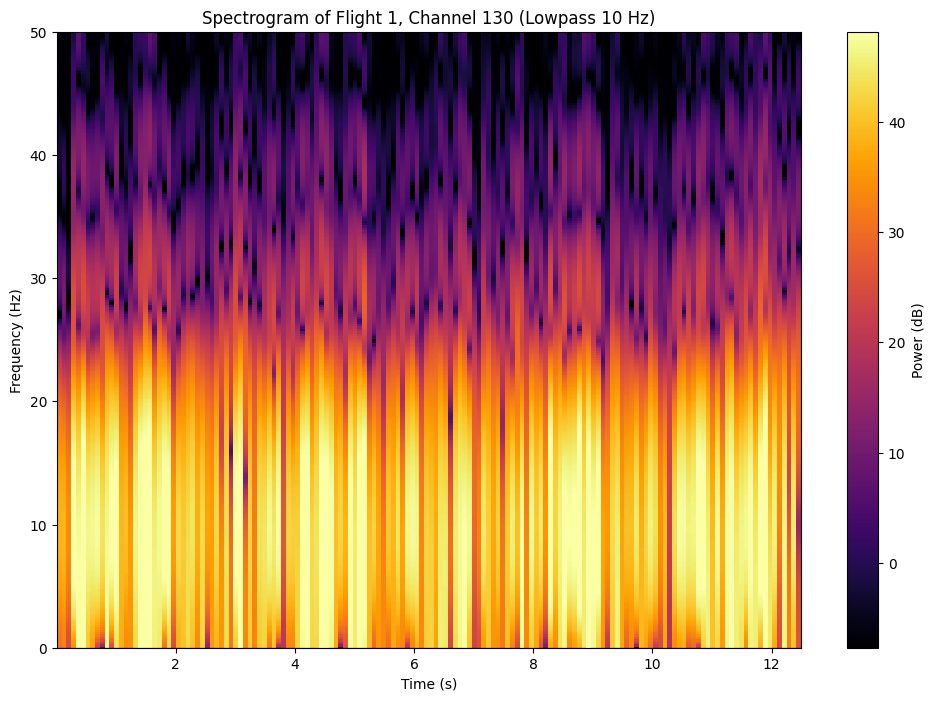

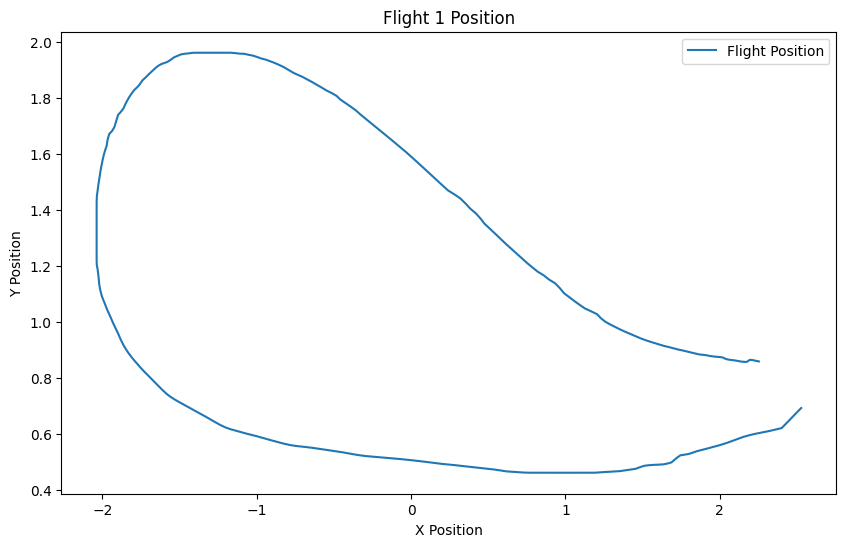

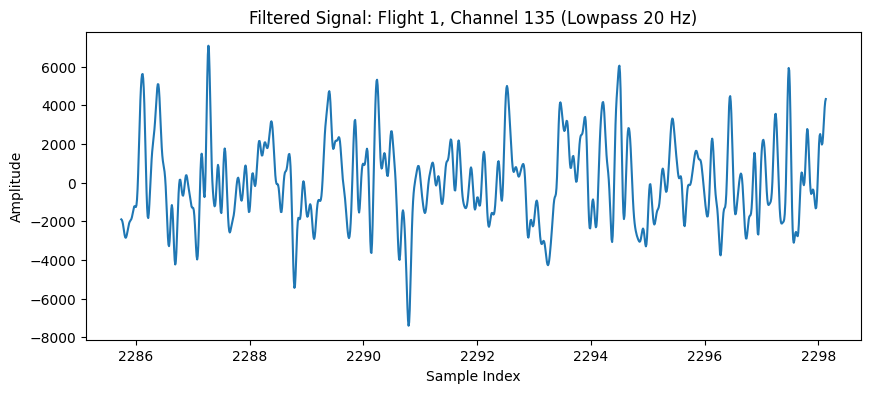

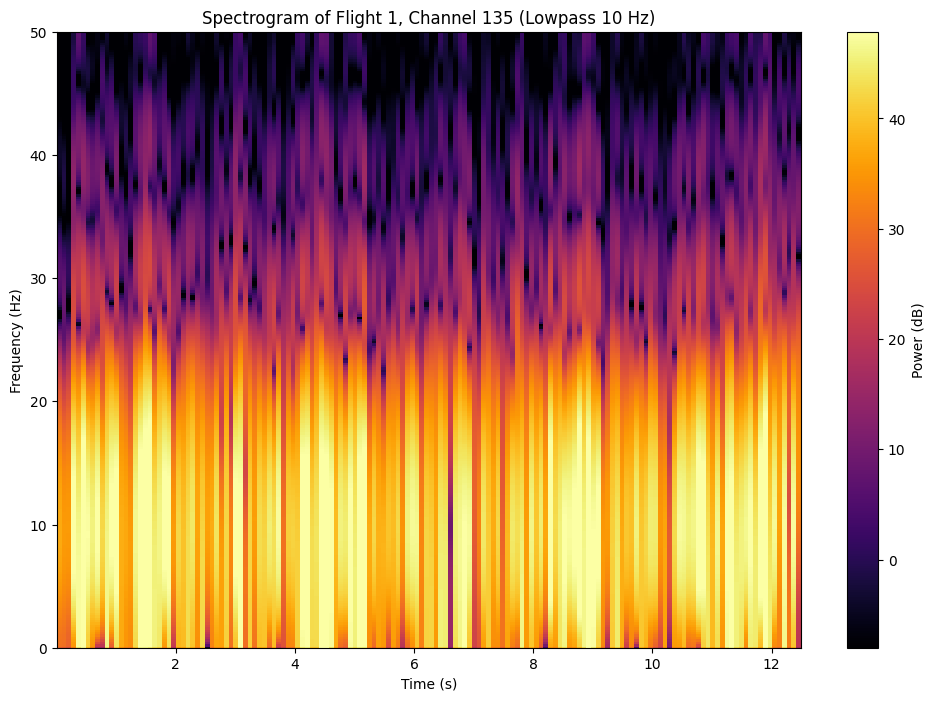

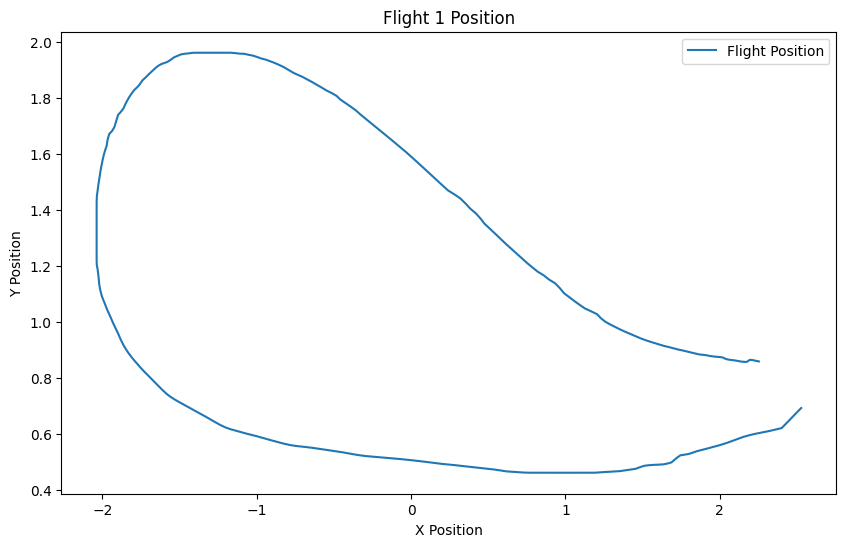

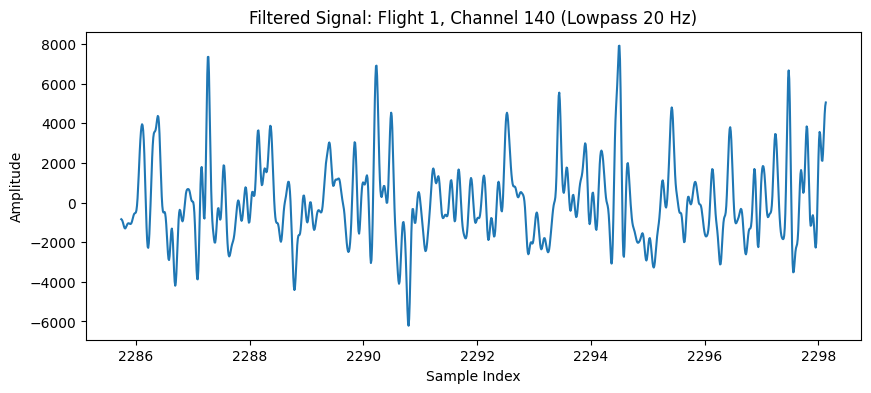

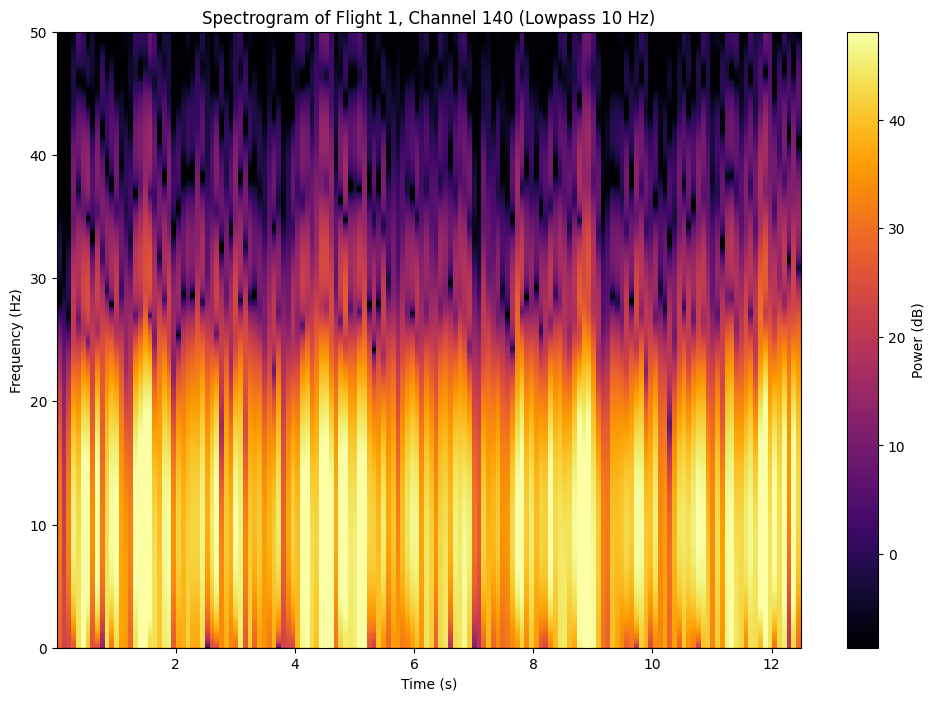

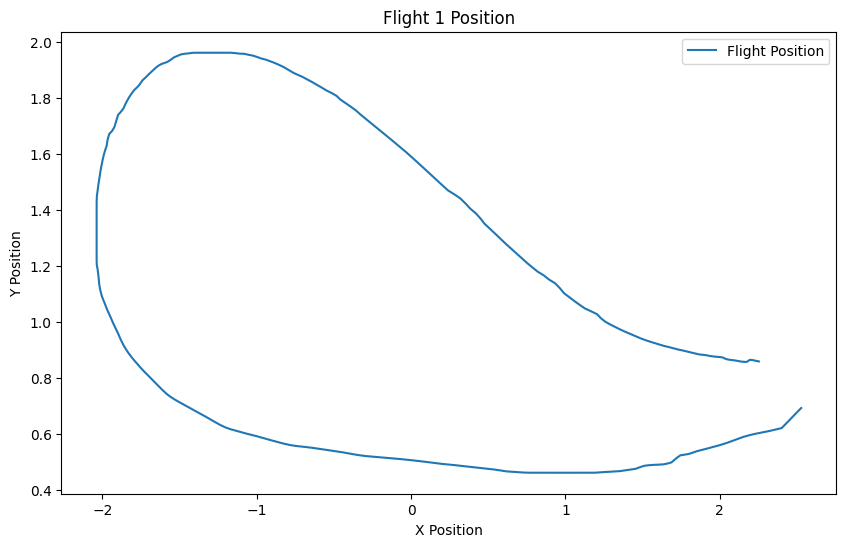

Flight 2: Flight LFP shape: (1244, 384)


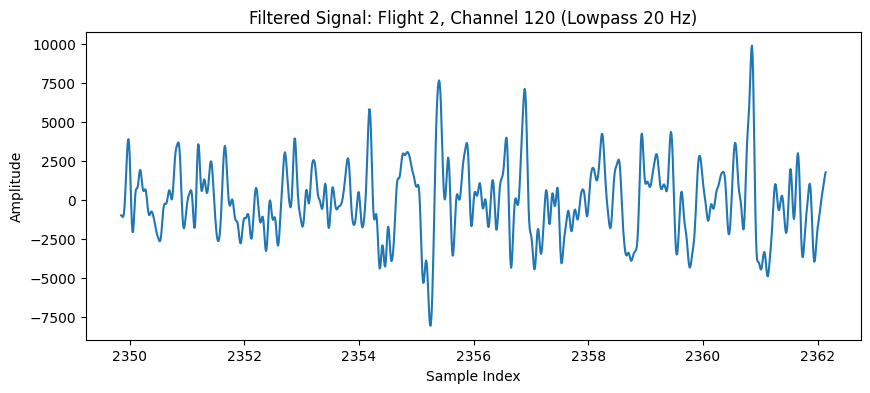

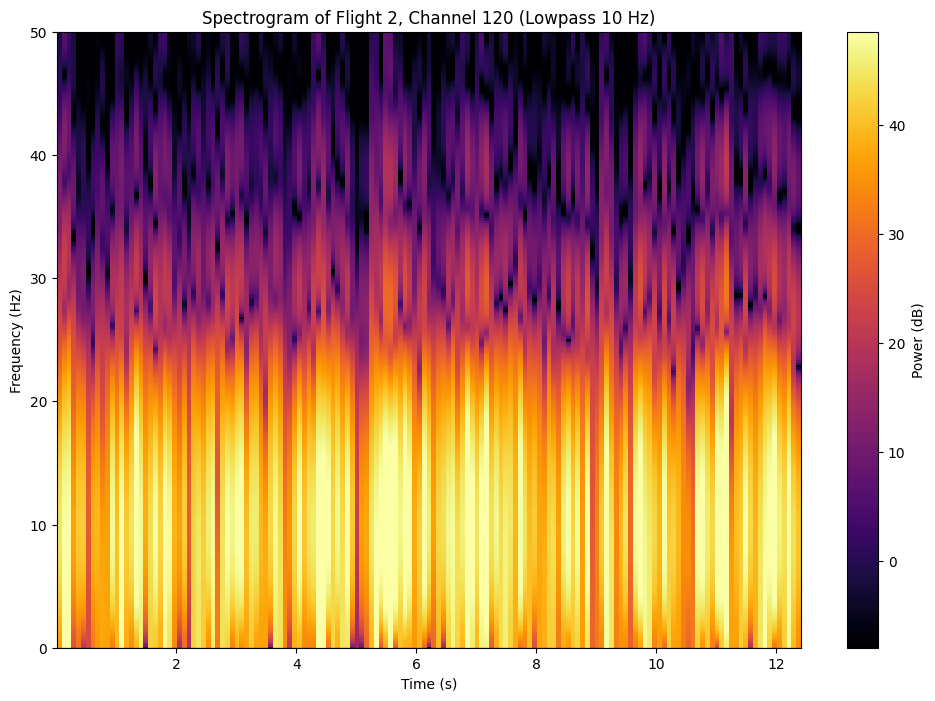

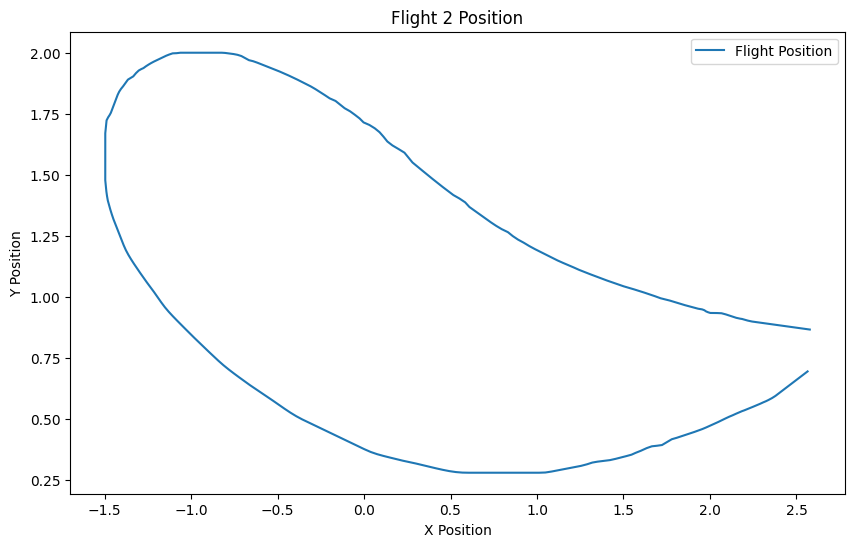

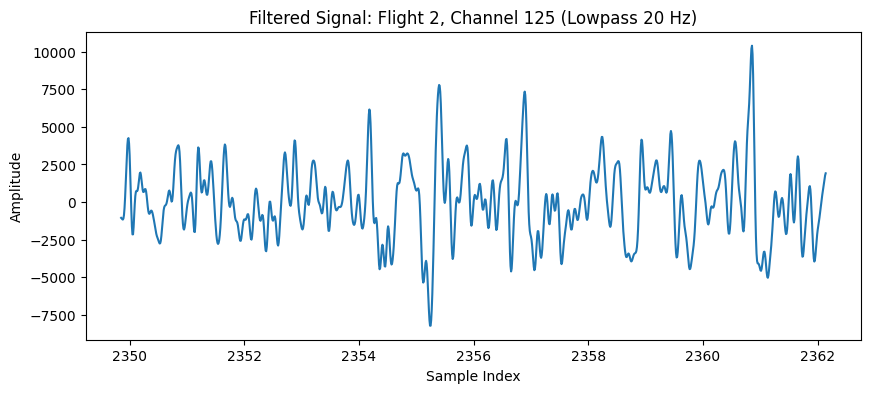

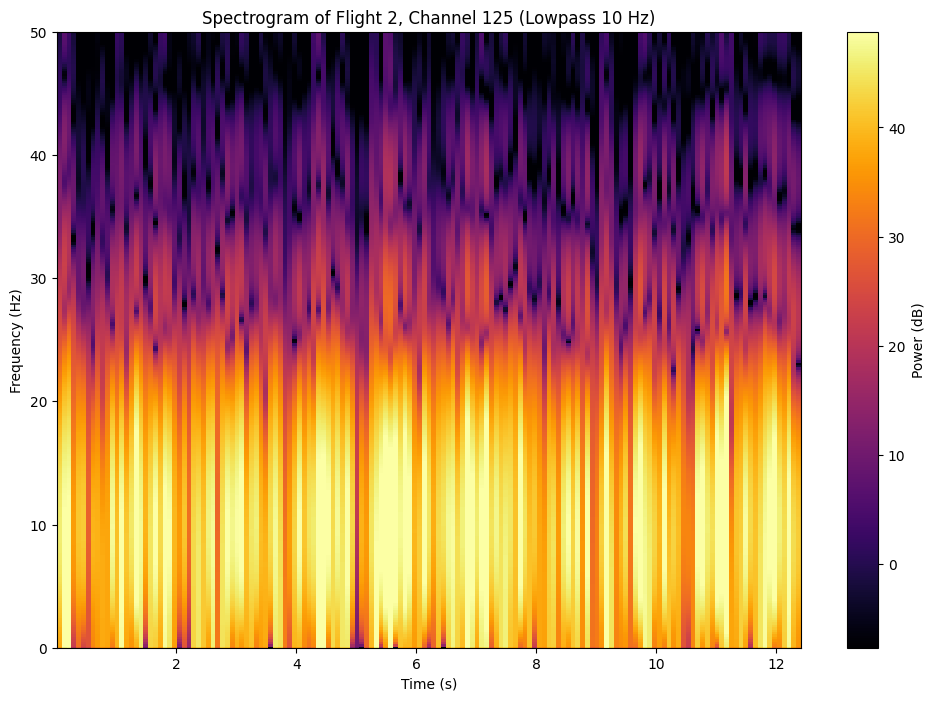

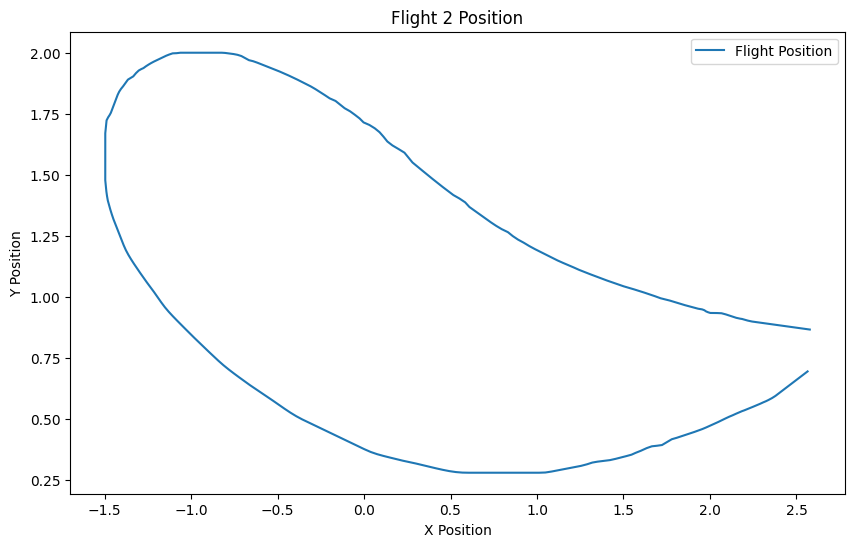

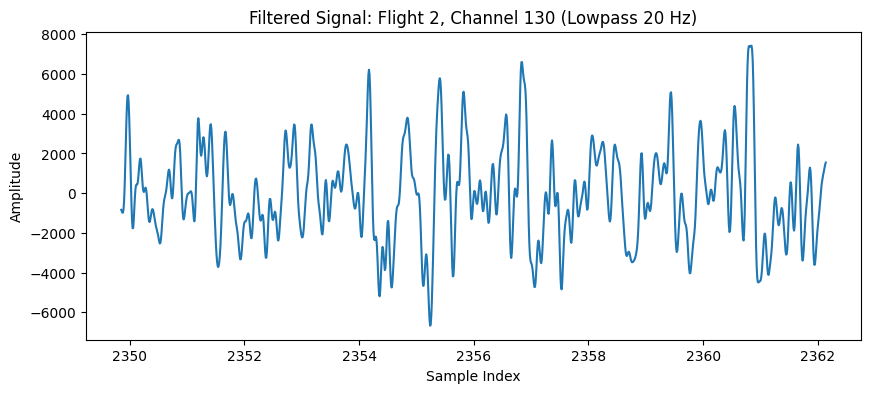

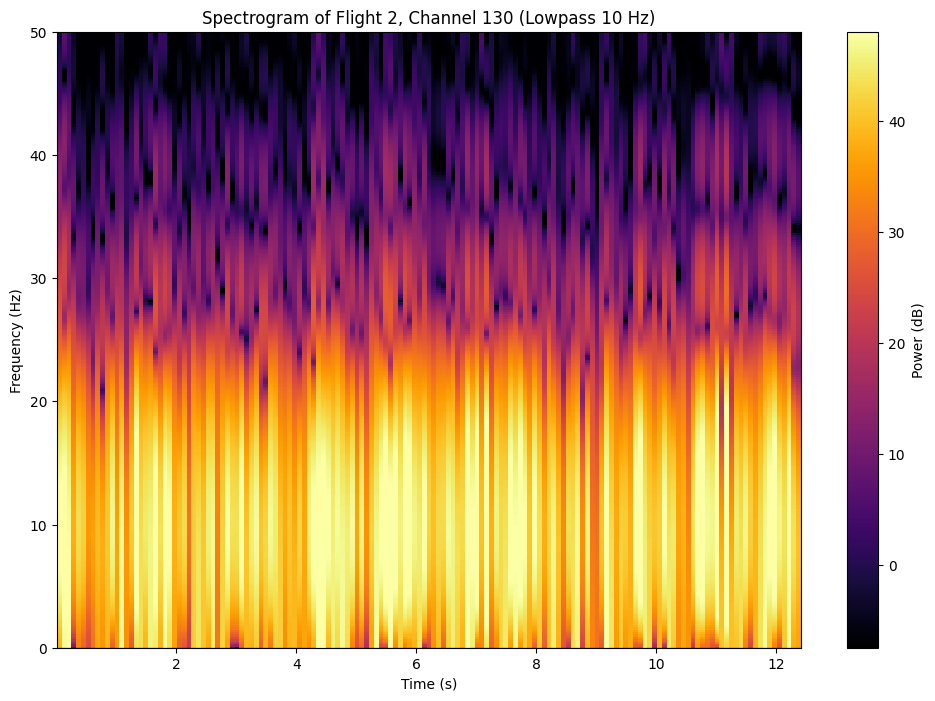

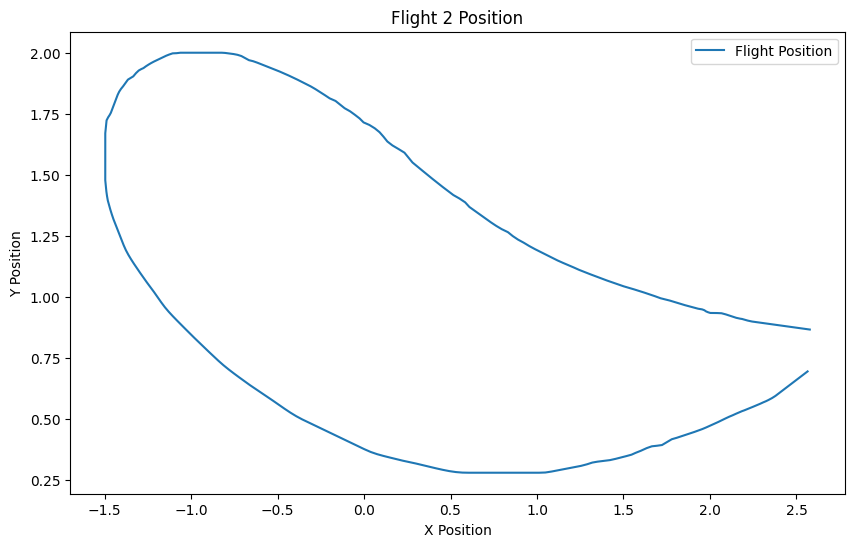

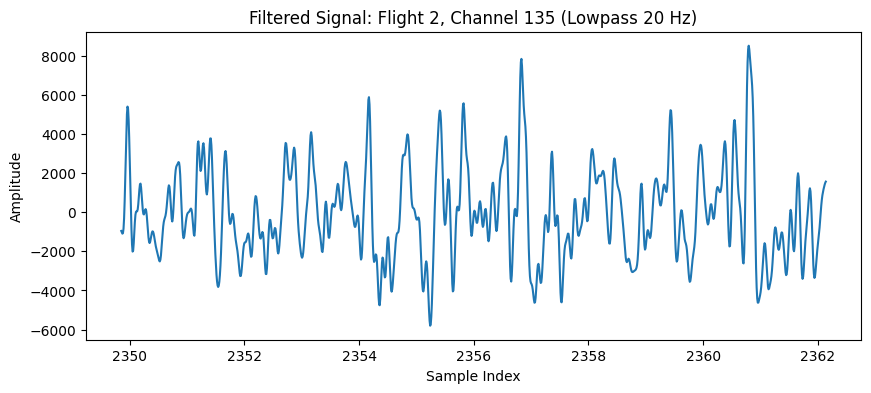

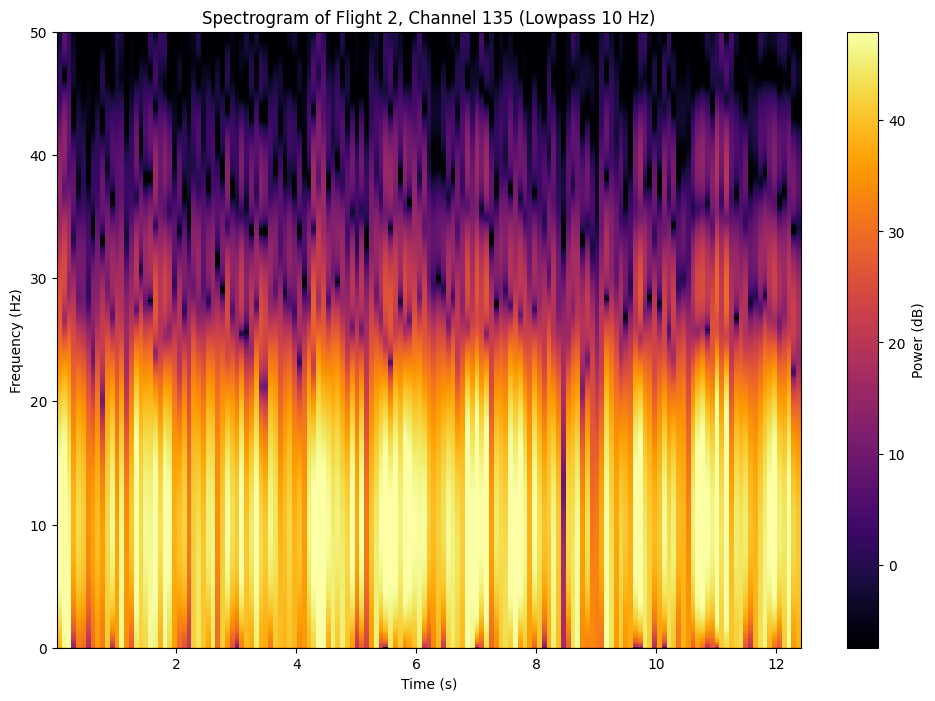

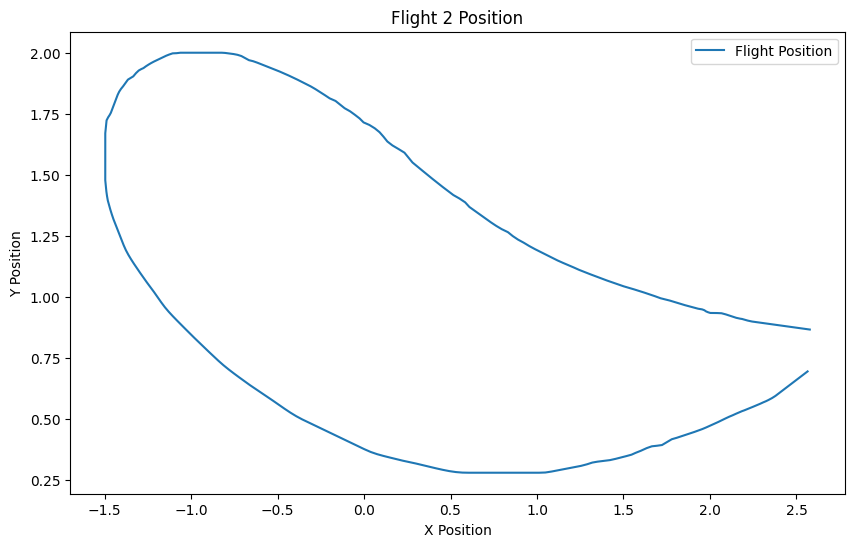

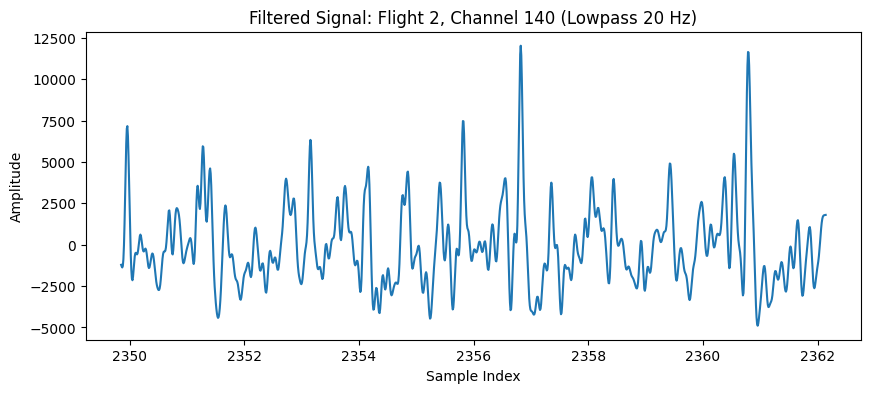

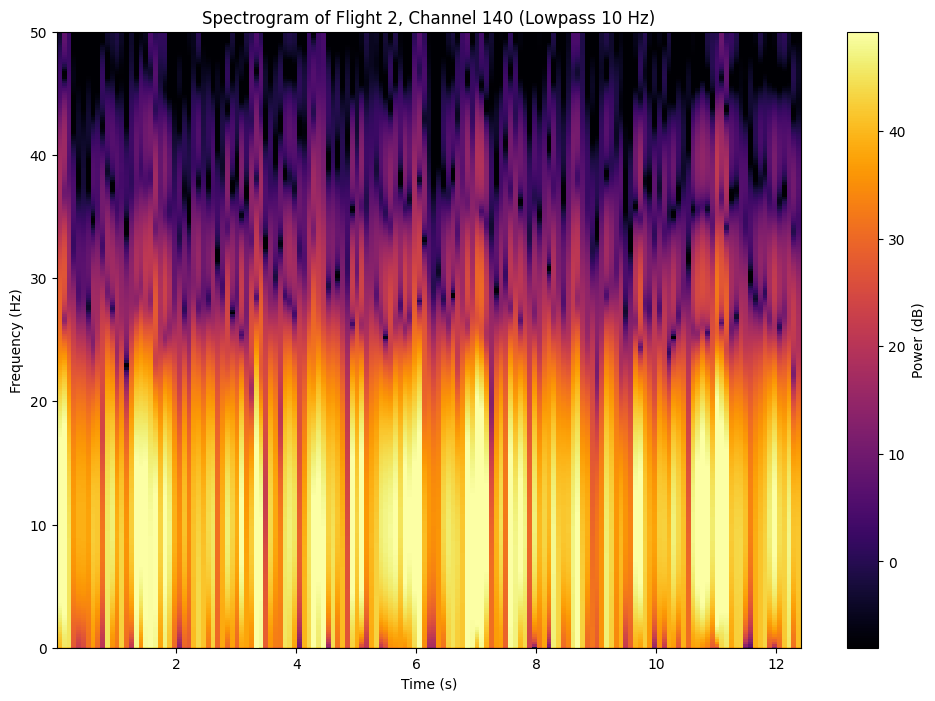

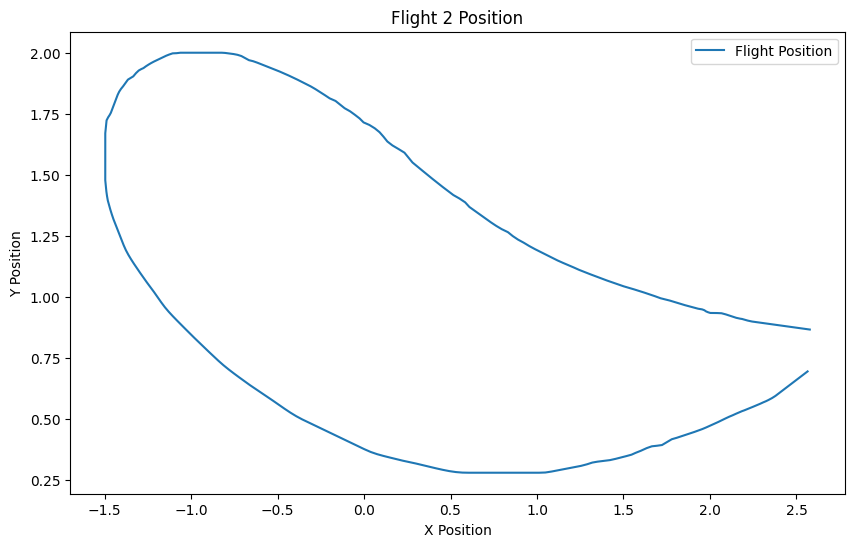

Flight 3: Flight LFP shape: (1252, 384)


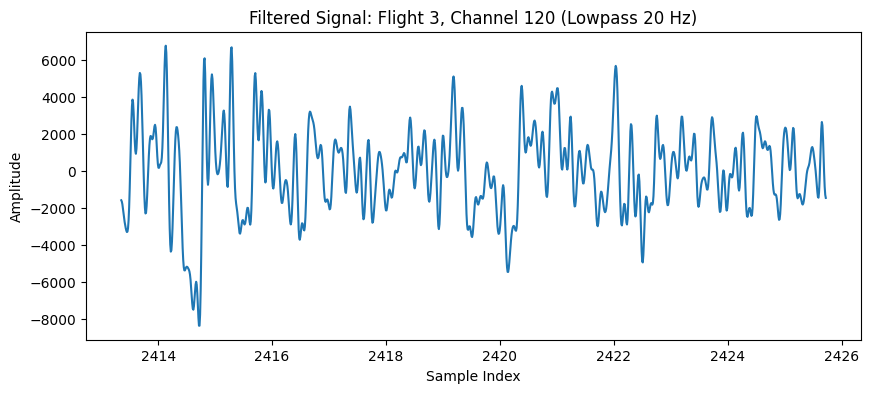

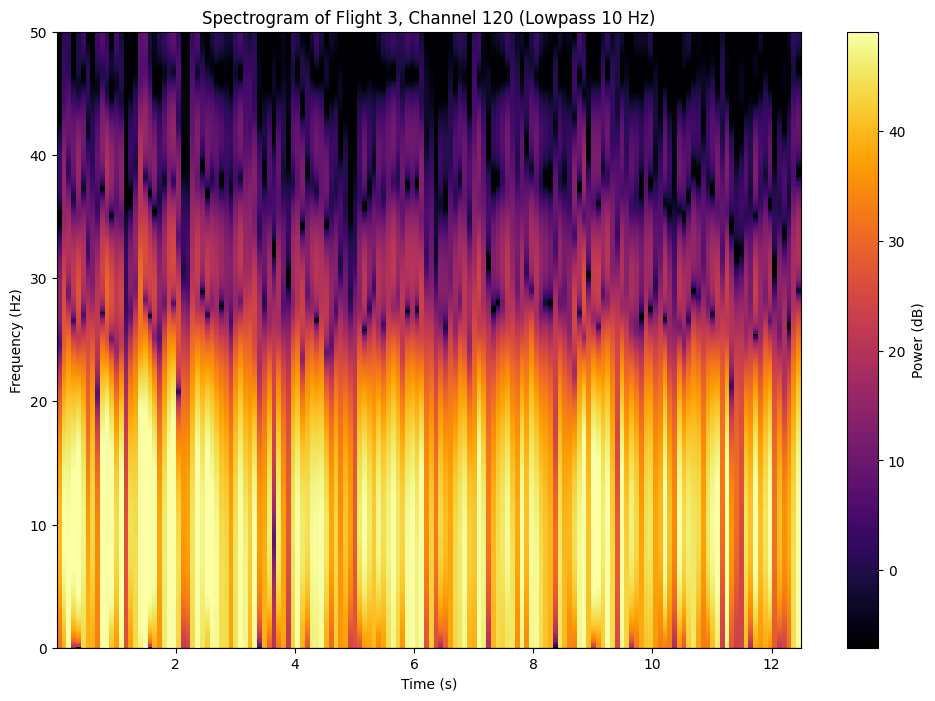

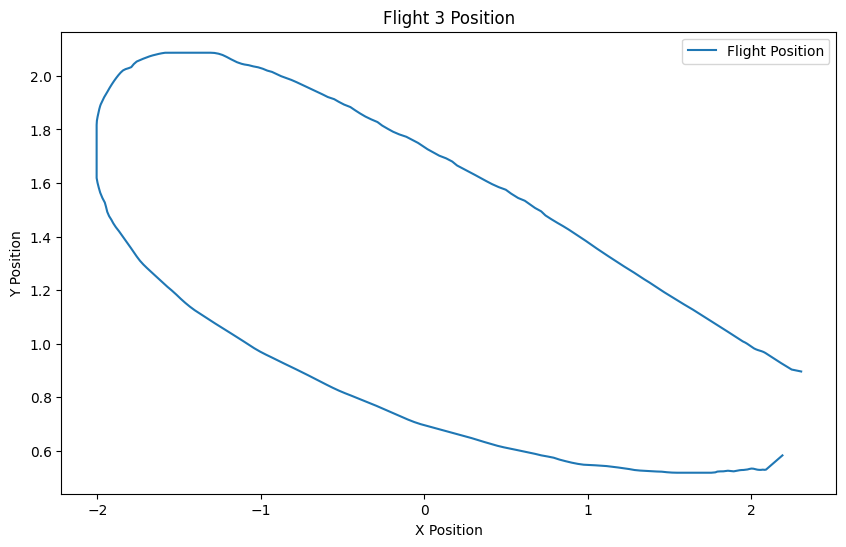

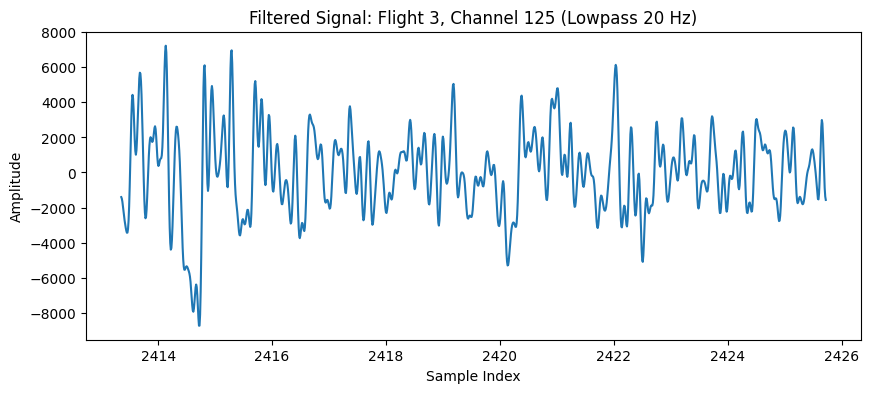

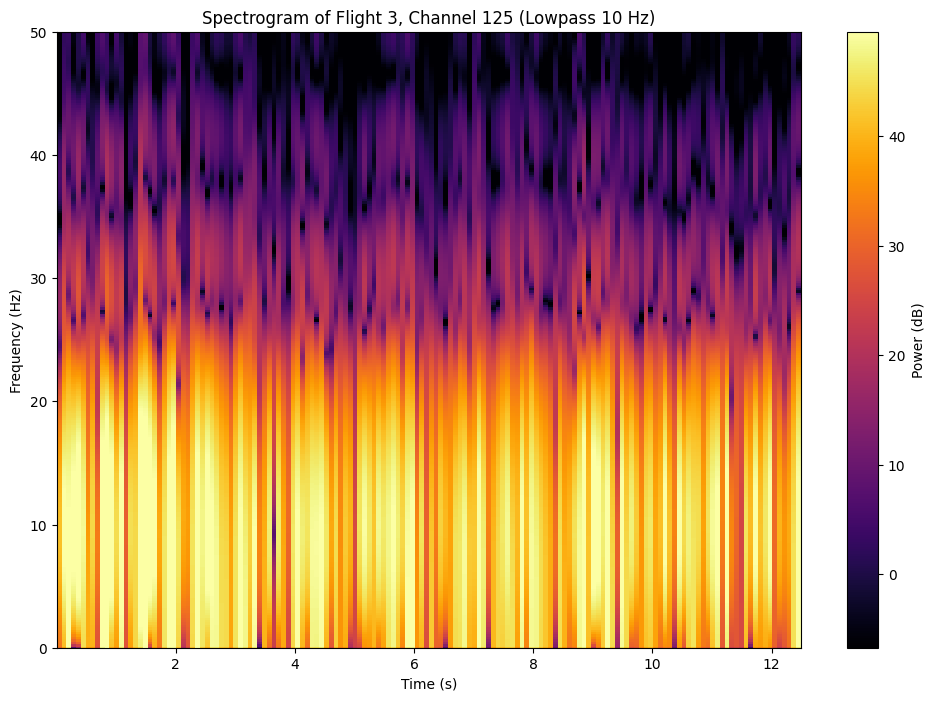

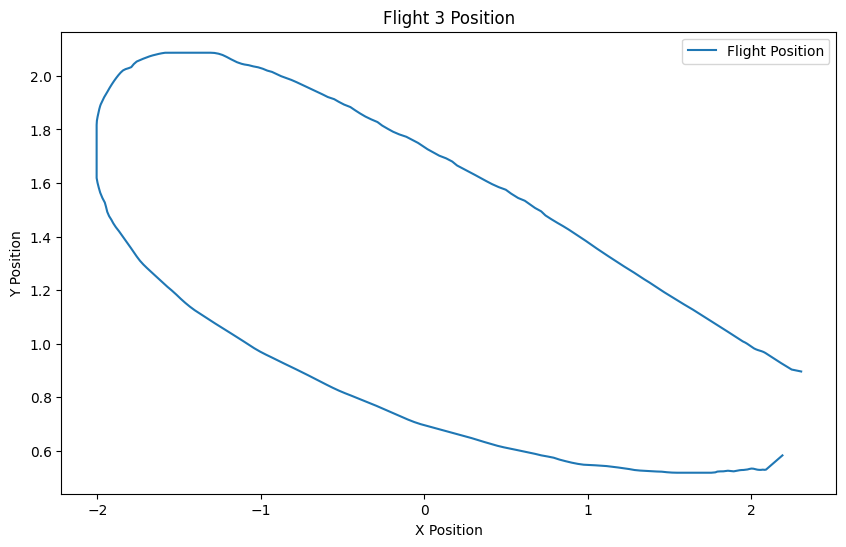

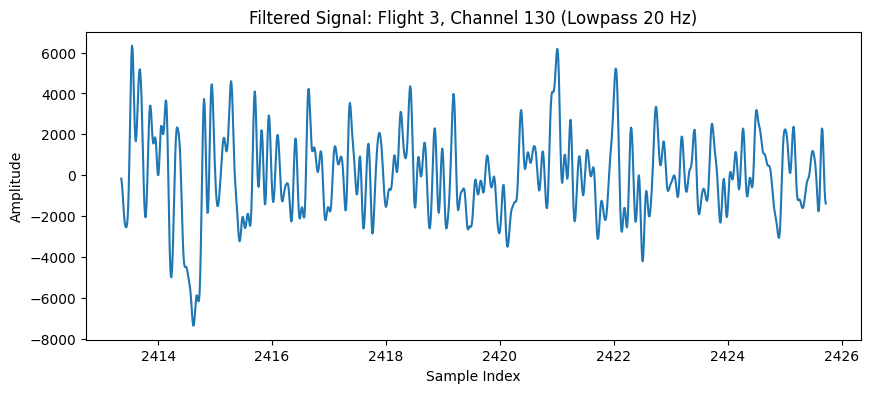

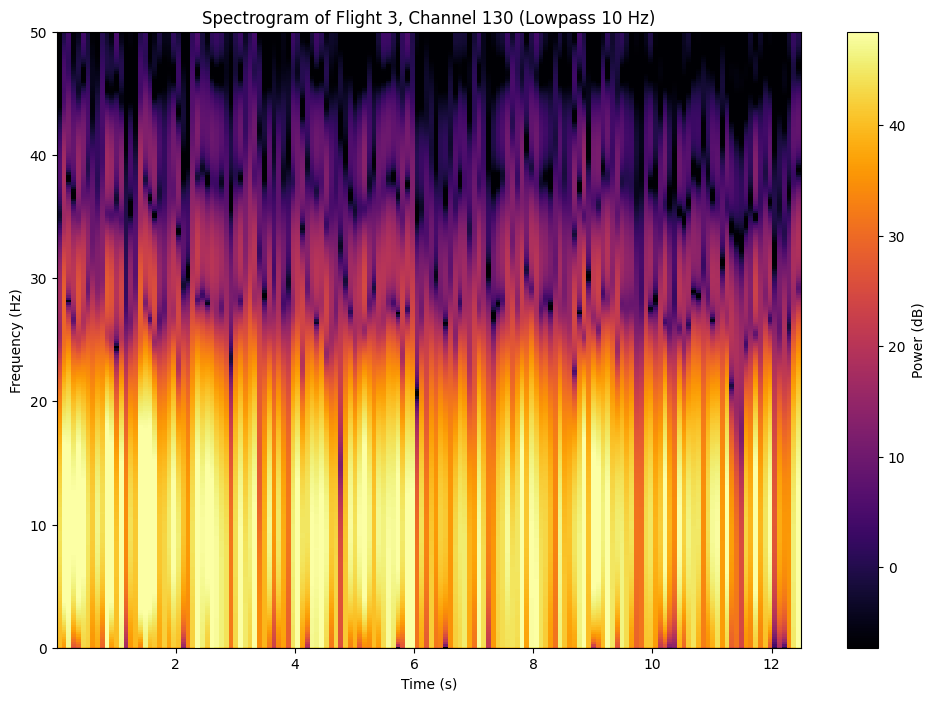

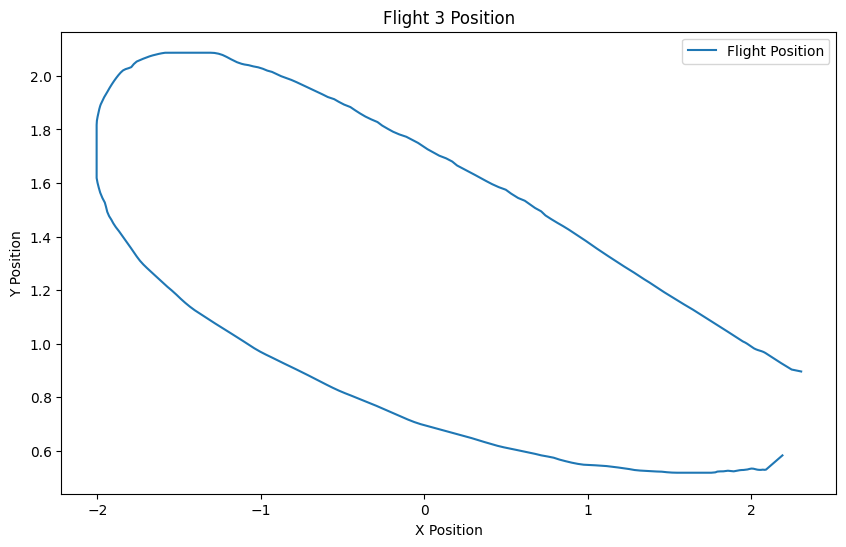

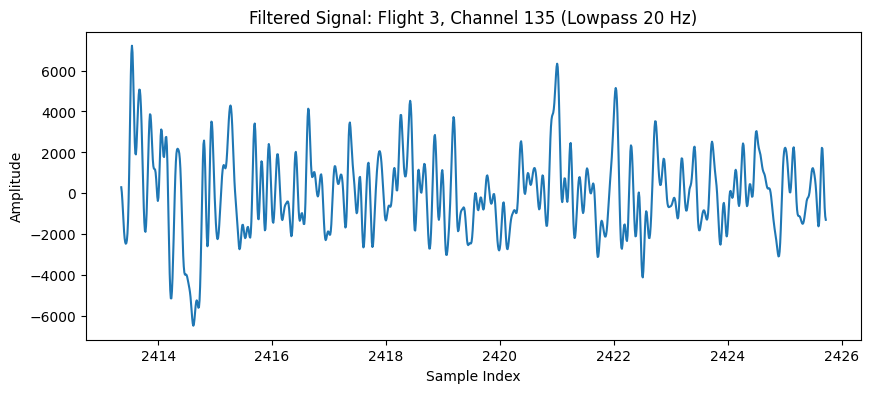

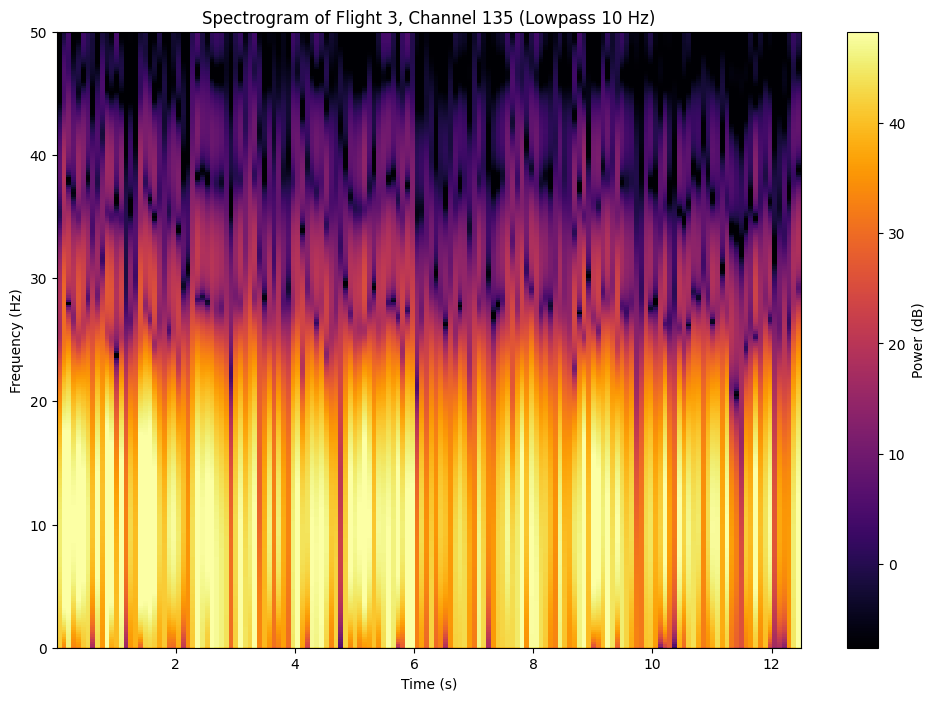

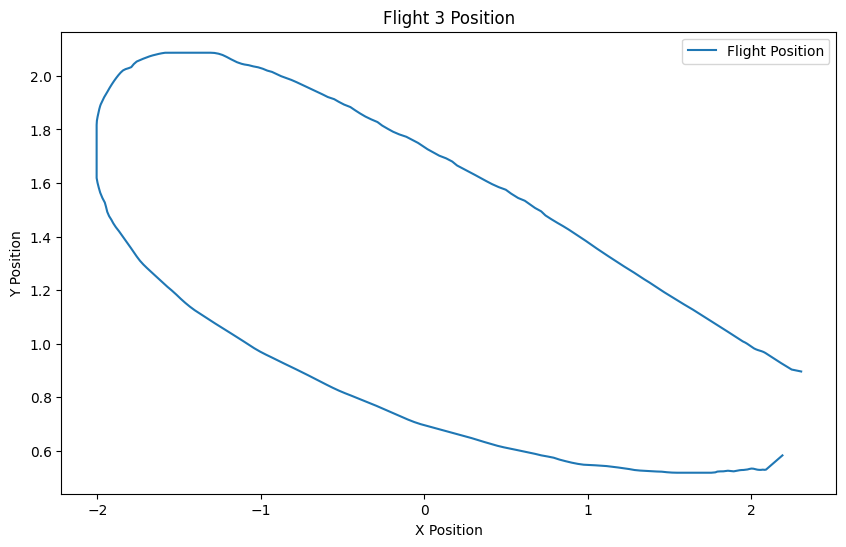

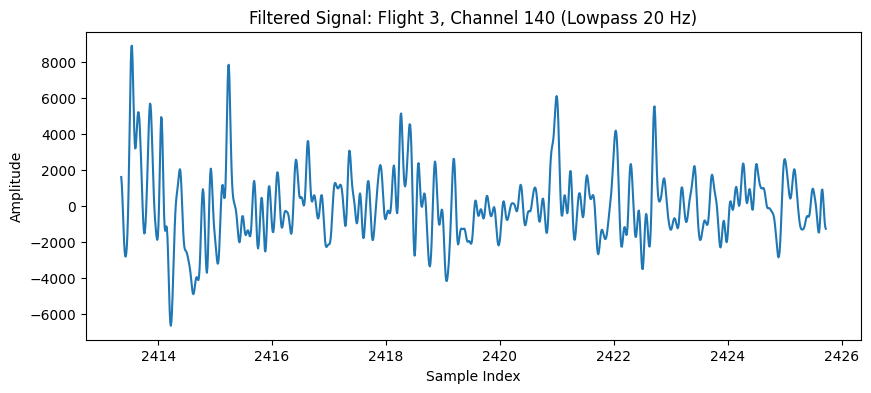

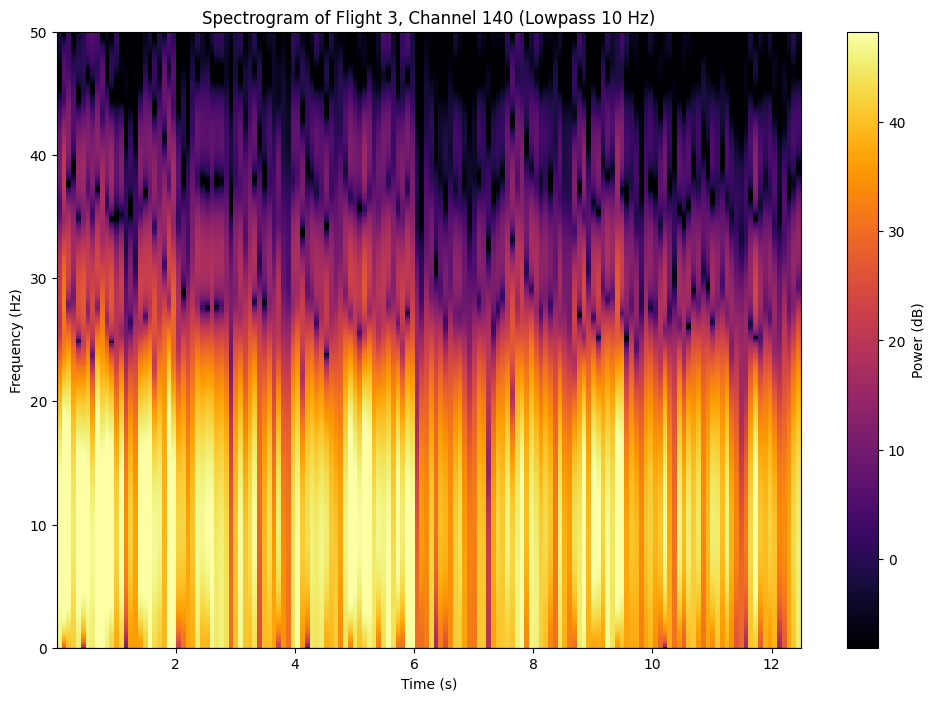

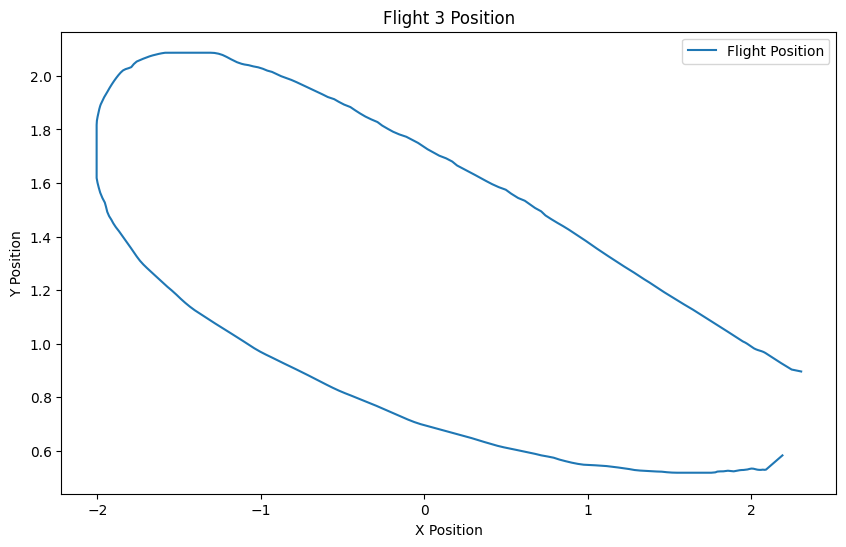

In [76]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import spectrogram, butter, filtfilt
import numpy as np

# Parameters
cluster = 1
off_samples = 500
sampling_rate = 100  # LFP sampling rate (Hz)
low_pass_20hz = 10  # Low-pass filter at 20 Hz
nperseg = 10  # Moderate segment length for better time resolution
noverlap = 2  # 50% overlap
nfft = 512  # Zero-padding for frequency interpolation
window_type = 'hann'  # Hann window to reduce spectral leakage
detrend_type = 'constant'  # Detrend each segment
channels_to_plot = range(120, 141, 5)  # Plot channels 80, 85, 90, 95, 100

# Butterworth low-pass filter design
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, method="gust")

# Iterate through all flights in cluster 2
flight_count = 0
cluster_flights = session.get_flights_by_cluster([1,])
for flight in cluster_flights[:3]:  # Limit to the first three flights
    flight_count += 1

    # Generate the boolean array for flight with off_samples
    flight_bool, phase_labels, _ = get_flight_boolean_array(session, flight_count, off_samples)

    # Apply valid_indices to the flight boolean array
    labels = flight_bool[pos_mask]
    valid_phase_labels = phase_labels[pos_mask]

    # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)

    # Adjust valid_phase_labels to match timebin_labels
    adjusted_phase_labels = label_timebins(lfp_timestamps_edges, valid_phase_labels, pos_timestamps, is_discrete=True)

    # Get LFP data for this flight
    flight_lfp = LFPs[timebin_labels > 0]
    
    flight_pos = binned_pos[timebin_labels > 0]

    # Check if data exists and process each channel
    if flight_lfp.size > 0:
        print(f"Flight {flight_count}: Flight LFP shape: {flight_lfp.shape}")

        # Ensure the signal has the expected number of channels
        if flight_lfp.ndim == 2 and flight_lfp.shape[1] >= 192:
            for channel in channels_to_plot:
                if channel >= flight_lfp.shape[1]:
                    print(f"Skipping channel {channel} for Flight {flight_count}: Channel out of range.")
                    continue

                channel_data = flight_lfp[:, channel]  # Select the specific channel

                # Apply low-pass filter
                channel_data = lowpass_filter(channel_data, low_pass_20hz, sampling_rate)
                
                # Plot the filtered signal for debugging
                plt.figure(figsize=(10, 4))
                plt.plot(lfp_timestamps_edges_trim[timebin_labels > 0] / 1e6, channel_data)
                plt.title(f"Filtered Signal: Flight {flight_count}, Channel {channel} (Lowpass 20 Hz)")
                plt.xlabel("Sample Index")
                plt.ylabel("Amplitude")
                plt.show()

                # Compute the spectrogram
                f, t, Sxx = spectrogram(
                    channel_data,
                    fs=sampling_rate,
                    window=window_type,
                    nperseg=nperseg,
                    noverlap=noverlap,
                    nfft=nfft,
                    detrend=detrend_type,
                    scaling='density',
                    mode='psd'
                )

                # Skip plotting if the spectrogram is empty
                if np.all(Sxx == 0) or np.all(np.isnan(Sxx)) or np.max(Sxx) < 1e-10:
                    print(f"Flight {flight_count}, Channel {channel}: Empty or invalid spectrogram. Skipping plot.")
                    continue

                # Plot the spectrogram below 20 Hz
                plt.figure(figsize=(12, 8))
                plt.pcolormesh(
                    t, f, 10 * np.log10(Sxx + 1e-10),
                    shading="auto",
                    cmap="inferno",  # Black -> Red -> Yellow -> White
                    norm=Normalize(vmin=np.percentile(10 * np.log10(Sxx + 1e-10), 5),
                                   vmax=np.percentile(10 * np.log10(Sxx + 1e-10), 95))
                )
                plt.colorbar(label="Power (dB)")
                plt.title(f"Spectrogram of Flight {flight_count}, Channel {channel} (Lowpass {low_pass_20hz} Hz)")
                plt.xlabel("Time (s)")
                plt.ylabel("Frequency (Hz)")
                plt.ylim(0, 50)  # Focus on frequencies below 20 Hz
                plt.show()
                
                # Plot the flight position
                plt.figure(figsize=(10, 6))
                plt.plot(flight_pos[:, 0], flight_pos[:, 1], label='Flight Position')
                plt.title(f"Flight {flight_count} Position")
                plt.xlabel("X Position")
                plt.ylabel("Y Position")
                plt.legend()
                plt.show()

        else:
            print(f"Flight {flight_count}: Insufficient channels. Skipping.")
    else:
        print(f"Flight {flight_count}: No LFP data found. Skipping.")


## training TIMBRE

In [16]:
label_mapping = {"left": 0, "right": 1}
classifications = flight_data[:,1]
# Assuming flight_data[:, 2] is a 2D array of strings
# Convert all elements to complex numbers while preserving the original shape
lfp_data = np.array([np.array([complex(val) for val in row]) for row in flight_data[:, 2:]])

# Map the labels to integers
Y = np.array([label_mapping[label] for label in classifications if label != "within buffer"])  # Exclude buffer range

# Extract the LFP data corresponding to non-"0" labels
X = lfp_data[classifications != "within buffer"]  # Use rows where the labels aren't "0"

In [ ]:
X

In [ ]:
# distribution of categorical labels
unique, counts = np.unique(Y, return_counts=True)
total = len(Y)
distribution = {label: (count / total) * 100 for label, count in zip(unique, counts)}
print(distribution)

In [ ]:
Y.shape, X.shape

In [ ]:
from sklearn.model_selection import KFold
from TIMBRE import TIMBRE

k = 3 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
hidden_nodes=3
learn_rate=0.1
is_categorical=True

# Assuming X and Y are your data and labels
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    # Use train_index and test_index to index into X and Y
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Call TIMBRE or other model with the current fold's train-test split
    model, fitted_model, test_acc = TIMBRE(
        X=X,
        Y=Y,
        inds_test=test_index,
        inds_train=train_index,
        hidden_nodes=hidden_nodes,
        learn_rate=learn_rate,
        is_categorical=is_categorical,
        verbosity=0
    )

    print(f"Fold {fold + 1} Test Accuracy: {test_acc}")

In [ ]:
from matplotlib import pyplot as plt

# Plot accuracy and loss from fittedModel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot training vs. validation accuracy
axs[0].plot(fitted_model.history['accuracy'], label='Train')
axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Training epoch')
axs[0].legend()

# Plot training vs. validation loss
axs[1].plot(fitted_model.history['loss'], label='Train')
axs[1].plot(fitted_model.history['val_loss'], label='Test')
axs[1].set_title('Loss')
axs[1].set_xlabel('Training epoch')
axs[1].legend()

plt.tight_layout()
plt.show()


In [22]:
from sklearn.model_selection import train_test_split

# Split indices into training and testing sets
inds_train, inds_test = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)

In [ ]:
from TIMBRE import TIMBRE
from matplotlib import pyplot as plt
import numpy as np

# Parameters for TIMBRE
hidden_node_sizes = [3, 10, 30]  # Hidden node sizes to test
learn_rate = 0.001
is_categorical = True
iterations = 3  # Number of iterations per hidden node size

# Store results
results = {size: [] for size in hidden_node_sizes}

# Loop over hidden node sizes and iterations
for hidden_nodes in hidden_node_sizes:
    for iteration in range(iterations):
        print(f"Testing hidden_nodes={hidden_nodes}, iteration={iteration + 1}")

        # Call TIMBRE
        model, fitted_model, test_acc = TIMBRE(
            X=X,
            Y=Y,
            inds_test=inds_test,
            inds_train=inds_train,
            hidden_nodes=hidden_nodes,
            learn_rate=learn_rate,
            is_categorical=is_categorical,
            verbosity=0  # Suppress detailed output for cleaner logs
        )

        # Store test accuracy
        results[hidden_nodes].append(test_acc)
        print(f"Test Accuracy: {test_acc}")

        # Plot accuracy and loss from fittedModel
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot training vs. validation accuracy
        axs[0].plot(fitted_model.history['accuracy'], label='Train')
        axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
        axs[0].set_title('Accuracy')
        axs[0].set_xlabel('Training epoch')
        axs[0].legend()

        # Plot training vs. validation loss
        axs[1].plot(fitted_model.history['loss'], label='Train')
        axs[1].plot(fitted_model.history['val_loss'], label='Test')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Training epoch')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

# Calculate average accuracy for each hidden node size
average_accuracies = {size: np.mean(accs) for size, accs in results.items()}

# Print results
print("\nResults:")
for size, accs in results.items():
    print(f"Hidden Nodes: {size}, Accuracies: {accs}, Average Accuracy: {average_accuracies[size]}")

# Plot results
fig, ax = plt.subplots(figsize=(10, 5))

hidden_sizes = list(average_accuracies.keys())
average_accs = list(average_accuracies.values())

ax.bar(hidden_sizes, average_accs, color='skyblue')
ax.set_title("Average Test Accuracy vs Hidden Node Size")
ax.set_xlabel("Hidden Node Size")
ax.set_ylabel("Average Test Accuracy")
plt.xticks(hidden_sizes)
plt.tight_layout()
plt.show()
